# Data Preprocessing
This is the second notebook for robust credit risk assessment in P2P lending in context of adversarial learning, and it focuses on data preprocessing.

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

## Loading the Dataset
We will load the data from a CSV file, and specify the data types for some columns to avoid warnings.

In [2]:
df = pd.read_csv(
    'data/LoanData.csv',
    dtype={

        'CreditScoreEsEquifaxRisk': 'category',
        'CreditScoreFiAsiakasTietoRiskGrade': 'category',
        'ActiveLateLastPaymentCategory': 'category',
        'LoanCancelled': 'boolean',
        'ContractEndDate': 'string',
        'DefaultDate': 'string',
    },
)
df['ContractEndDate'] = pd.to_datetime(df['ContractEndDate'],format='ISO8601')
df['DefaultDate'] = pd.to_datetime(df['DefaultDate'],format='ISO8601')
df['LoanDate'] = pd.to_datetime(df['LoanDate'], format='ISO8601')

df.head()

,LoanId,LoanNumber,ListedOnUTC,BiddingStartedOn,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,LoanApplicationStartedDate,LoanDate,...,GracePeriodEnd,NextPaymentDate,NextPaymentNr,NrOfScheduledPayments,ReScheduledOn,PrincipalDebtServicingCost,InterestAndPenaltyDebtServicingCost,ActiveLateLastPaymentCategory,LoanCancelled,PreviousEarlyRepaymentsBeforeLoan
0,D8EBF360-104C-420F-BEC9-000924E6EFC7,3015853,2022-09-09 12:27:01,2022-09-09 15:27:01,11.0,0.0,88.0,False,2022-09-09 15:15:03,2022-09-09,...,NaN,2024-05-27,6.0,23.0,2023-11-30,NaN,NaN,NaN,<NA>,NaN
1,C1A98DDA-5E20-429C-BBFF-0009A05354E0,3743447,2023-05-19 11:04:33,2023-05-19 14:04:33,0.0,0.0,0.0,False,2023-05-19 14:03:54,2023-05-19,...,NaN,2024-05-27,11.0,120.0,2023-07-20,NaN,NaN,91-120,<NA>,NaN
2,9B0B252E-45B9-4172-8E2D-0014A8F18117,4335414,2024-02-03 14:43:32,2024-02-03 16:43:32,0.0,0.0,0.0,False,2024-02-03 16:41:51,2024-02-03,...,NaN,2024-07-08,2.0,12.0,2024-05-12,NaN,NaN,NaN,<NA>,NaN
3,66AE108B-532B-4BB3-BAB7-0019A46412C1,483449,2016-03-23 16:07:19,2016-03-23 16:07:19,970.0,1150.0,5.0,False,2016-03-17 12:39:22,2016-03-23,...,2020-01-27,NaN,NaN,NaN,NaN,0.0,82.76,180+,<NA>,0.0
4,C7EA512A-465D-4043-A9F2-001B14C3C14E,4043783,2023-09-26 12:14:12,2023-09-26 15:14:12,0.0,0.0,0.0,False,2023-09-26 15:13:07,2023-09-26,...,NaN,2024-06-04,9.0,108.0,NaN,NaN,NaN,16-30,<NA>,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400170 entries, 0 to 400169
Data columns (total 97 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   LoanId                                  400170 non-null  object        
 1   LoanNumber                              400170 non-null  int64         
 2   ListedOnUTC                             400170 non-null  object        
 3   BiddingStartedOn                        400170 non-null  object        
 4   BidsPortfolioManager                    400170 non-null  float64       
 5   BidsApi                                 400170 non-null  float64       
 6   BidsManual                              400170 non-null  float64       
 7   NewCreditCustomer                       400170 non-null  bool          
 8   LoanApplicationStartedDate              400170 non-null  object        
 9   LoanDate                             

## Defining the Target Variable
Our goal is to predict credit risk assessment, to do so, we shall predict loan default. Based on the specification, the `DefaultDate` column indicates the date of default. If the date is missing (NaT), it has not (or has not yet) defaulted. We will create a binary target variable, `is_default`, from this column.

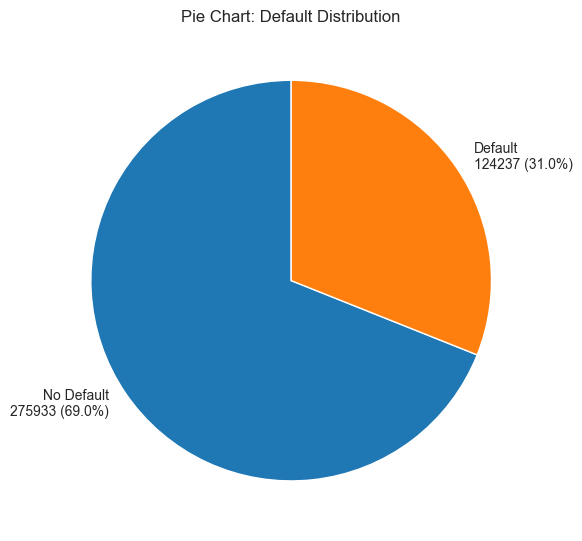

In [4]:
# Create the target variable
df['is_default'] = np.where(df['DefaultDate'].notnull(), 1, 0)

# Count and percentage
counts = df['is_default'].value_counts()
percentages = counts / counts.sum() * 100

# Create labels with percentage and count
labels = [
    f"{'No Default' if idx == 0 else 'Default'}\n{count} ({pct:.1f}%)"
    for idx, count, pct in zip(counts.index, counts.values, percentages.values)
]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=labels,
    startangle=90,
)
plt.title('Pie Chart: Default Distribution')
plt.tight_layout()
plt.show()

## Selecting Features
Some features might not be appropriate for further analysis, including features that:

- Leak information about the future.
- Are unique identifiers.
- Are explicitly marked as obsolote by Bondora.
- Are outputs from Bondora's own risk assessment system.

As there are more features that do not adhere to these criteria that do, we will define a list of features to keep, rather than specifying which to drop. We will only keep features that are known pre-approval or at the exact moment of approval of the loan.

In [5]:
demographic_features = [
    'Age',
    'Gender',
    'Education',
    'EmploymentDurationCurrentEmployer',
    'OccupationArea',
    'HomeOwnershipType'
]

loan_application_features = [
    'AppliedAmount',
    'LoanDuration',
    'VerificationType',
    'ApplicationSignedHour',
    'ApplicationSignedWeekday',
    'MonthlyPaymentDay',
]

financial_health_features = [
    'ExistingLiabilities',
    'RefinanceLiabilities',
    'LiabilitiesTotal',
    'IncomeTotal',

]

previous_loan_features = [
    'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan',
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsCountBeforeLoan',
    'NewCreditCustomer',
    'DebtToIncome',
    'FreeCash',
]
external_credit_scores = [
    'CreditScoreEsEquifaxRisk',
    'CreditScoreFiAsiakasTietoRiskGrade',
    'CreditScoreEeMini',
    'CreditScoreEsMicroL'
 ]



target_col = ['is_default']

cols_to_keep = (
    demographic_features +
    loan_application_features +
    financial_health_features +
    previous_loan_features +
    ['LoanDate'] + # Kept only for splitting the data later
    target_col +
    external_credit_scores
)



df_cleaned = df[cols_to_keep].copy()

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400170 entries, 0 to 400169
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Age                                     400170 non-null  int64         
 1   Gender                                  400125 non-null  float64       
 2   Education                               400120 non-null  float64       
 3   EmploymentDurationCurrentEmployer       386276 non-null  object        
 4   OccupationArea                          400079 non-null  float64       
 5   HomeOwnershipType                       398513 non-null  float64       
 6   AppliedAmount                           400170 non-null  float64       
 7   LoanDuration                            400170 non-null  int64         
 8   VerificationType                        400120 non-null  float64       
 9   ApplicationSignedHour                

### Interpretation

Important to note is that a survey with domain experts has been conducted prior to this work. From this survey, certain features were described as very important (5), important (4), and categories that indicated less importance. These features are as follows:

- Ranked 5 (very important):
    - CreditScoreEsEquifaxRisk, DefaultDate, InterestRecovery, EAD1, EAD2, CreditScoreEeMini, InterestAndPenaltyBalance, CreditScoreFiAsiakasTietoRiskGrade, RecoveryStage, CreditScoreEsMicroL, Rating, ExpectedReturn, LossGivenDefault, ProbabilityOfDefault, Amount, AppliedAmount, Interest, LoanDuration, NewCreditCustomer
- Ranked 4 (important):
    - HomeOwnershipType, DebtToIncome, IncomeFromChildSupport, IncomeFromFamilyAllowance, IncomeFromLeavePay, IncomeFromPension, IncomeFromPrincipalEmployer, IncomeFromSocialWelfare, IncomeOther, IncomeTotal, LoanCancelled, PreviousEarlyRepaymentsBeforeLoan, GracePeriodEnd, GracePeriodStart, InterestAndPenaltyDebtServicingCost, PrincipalDebtServicingCost, PrincipalWriteOffs, ReScheduledOn, ActiveLateCategory, WorseLateCategory, PrincipalOverdueBySchedule, EmploymentDurationCurrentEmployer, ExistingLiabilities, LiabilitiesTotal, PrincipalBalance, RefinanceLiabilities

Considering the criteria above, not all features that were ranked as very important or important are included in the dataset.

## Dropping Obsolete Features (Bondora)
In order to ensure that we do not use features that are marked as obsolote by Bondora, we will drop the columns that are marked as such in the specification. (sanity check)

In [7]:
specification = pd.read_csv('data/public_dataset_item.csv')

col_name_col = None
info_col = None

for col in specification.columns:
    if 'name' in col.lower():
        col_name_col = col
    if 'info' in col.lower():
        info_col = col

#if col_name_col and info_col:
#    obsolete_features = specification[
#        specification[info_col].str.contains('Obsolete', na=False)
#    ][col_name_col].tolist()

#    features_to_drop = [col for col in obsolete_features if col in df_cleaned.columns]
#    if features_to_drop:
#        df_cleaned = df_cleaned.drop(columns=features_to_drop, errors='ignore')
  #      print(f"Dropped obsolete features: {features_to_drop}")
 #   else:
 #       print("No obsolete features dropped.")
#else:
 #   print("Expected columns not found in specification. Skipping drop.")

## Handling Missing Values

In [8]:
def missing_summary(df):
    """Returns a summary of missing values in the DataFrame."""
    missing_count = df.isnull().sum()
    missing_pct = 100 * missing_count / len(df)
    return pd.DataFrame({
        'missing_count': missing_count,
        'missing_pct': missing_pct
    }).loc[missing_count > 0].sort_values(by='missing_pct', ascending=False)

missing_summary(df_cleaned)

,missing_count,missing_pct
CreditScoreEsEquifaxRisk,387951,96.946548
CreditScoreEeMini,230377,57.569783
CreditScoreFiAsiakasTietoRiskGrade,217358,54.316416
PreviousRepaymentsBeforeLoan,152193,38.032086
CreditScoreEsMicroL,32400,8.096559
EmploymentDurationCurrentEmployer,13894,3.472024
HomeOwnershipType,1657,0.414074
OccupationArea,91,0.022740
PreviousEarlyRepaymentsCountBeforeLoan,83,0.020741
NoOfPreviousLoansBeforeLoan,82,0.020491


In [9]:
   
# Flag and fill previous‐loan features
prev_cols = [
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsCountBeforeLoan',
    'NoOfPreviousLoansBeforeLoan',
    'AmountOfPreviousLoansBeforeLoan',
]
for col in prev_cols:
    df_cleaned[f'{col}_missing'] = df_cleaned[col].isna().astype(int)
    df_cleaned[col] = df_cleaned[col].fillna(0)

# Treat missing employment duration as its own category
df_cleaned['EmploymentDurationCurrentEmployer'] = (
    df_cleaned['EmploymentDurationCurrentEmployer']
    .fillna('Unknown')
    .astype('category')
)

# Small gaps in Education, Gender, VerificationType, drop the rows where these are missing
if df_cleaned['Education'].isnull().any():
    df_cleaned = df_cleaned.dropna(subset=['Education'])


# Drop rows with missing HomeOwnershipType and OccupationArea (very few)
df_cleaned = df_cleaned.dropna(subset=['HomeOwnershipType', 'OccupationArea'])


missing_summary(df_cleaned)

,missing_count,missing_pct
CreditScoreEsEquifaxRisk,386294,96.933852
CreditScoreEeMini,228722,57.393862
CreditScoreFiAsiakasTietoRiskGrade,215701,54.126465
CreditScoreEsMicroL,30743,7.714428


### Interpretation

Most missingness falls are values that a structurally absent; values that are absent because the information never exists for some customers (e.g., previous-loan count for first-time borrowers). → We add a binary “_missing” flag and set the numeric field to 0. This preserves the signal that something was missing while keeping the feature numeric.

## Checking each remaining column
We will check each remaining column to ensure that it is appropriate for further analysis. This includes checking the data types, unique values, and any potential issues.

In [10]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398513 entries, 0 to 400169
Data columns (total 33 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   Age                                             398513 non-null  int64         
 1   Gender                                          398513 non-null  float64       
 2   Education                                       398513 non-null  float64       
 3   EmploymentDurationCurrentEmployer               398513 non-null  category      
 4   OccupationArea                                  398513 non-null  float64       
 5   HomeOwnershipType                               398513 non-null  float64       
 6   AppliedAmount                                   398513 non-null  float64       
 7   LoanDuration                                    398513 non-null  int64         
 8   VerificationType                       

In [11]:
def inspector(column_name):
    """Inspect a column in the DataFrame."""
    col = df_cleaned[column_name]
    print(f"Column: {column_name}")
    print(f"Data type: {col.dtype}")
    print(f"All unique values: {col.unique()}")
    print(f"Sample values: {col.sample().values}")
    print(f"Missing values: {col.isnull().sum()}")

In [12]:
# 1. Define mappings per column
map_dicts = {
    'CreditScoreEsEquifaxRisk': {'A': 1, 'AA': 2, 'B': 3, 'C': 4, 'D': 5, 'AAA': 6},
    'CreditScoreEeMini': None,  # Assume numeric, just convert directly
    'CreditScoreFiAsiakasTietoRiskGrade': {
        **{str(i): i for i in range(1, 9)},
        **{'RL0': 9, 'RL1': 10, 'RL2': 11, 'RL3': 12, 'RL4': 13, 'RL5': 14}
    },
    'CreditScoreEsMicroL': {'M': 0, 'M1': 1, 'M2': 2, 'M3': 3, 'M4': 4, 'M5': 5, 'M6': 6, 'M7': 7, 'M8': 8, 'M9': 9, 'M10': 10}
}

# 2. List of columns to transform
credit_score_cols = [
    'CreditScoreEsEquifaxRisk',
    'CreditScoreEeMini',
    'CreditScoreFiAsiakasTietoRiskGrade',
    'CreditScoreEsMicroL'
]

# 3. Inspect raw unique values for debugging
print("=== Unique values in raw columns ===")
for col in credit_score_cols:
    print(f"{col}: {df_cleaned[col].unique()}")

# 4. Loop through columns, map, flag missing, fill missing robustly
for col in credit_score_cols:
    num_col = f"{col}_num"
    missing_col = f"{col}_missing"

    # Map or convert numeric depending on mapping availability
    if map_dicts[col] is not None:
        df_cleaned[num_col] = df_cleaned[col].map(map_dicts[col])
    else:
        df_cleaned[num_col] = pd.to_numeric(df_cleaned[col], errors='coerce')

    # Show any unmapped values for review
    unmapped = df_cleaned[df_cleaned[num_col].isna()][col].unique()
    if len(unmapped) > 0:
        print(f"Unmapped values in {col}: {unmapped}")

    # Create missing flag column
    df_cleaned[missing_col] = df_cleaned[num_col].isna().astype(int)

    # Convert to numeric and fill missing with 0
    df_cleaned[num_col] = pd.to_numeric(df_cleaned[num_col], errors='coerce').fillna(0)

# 5. Summarize missing values after mapping
missing_summary = df_cleaned[[f"{col}_missing" for col in credit_score_cols]].sum().reset_index()
missing_summary.columns = ['column', 'missing_count']
missing_summary['missing_pct'] = 100 * missing_summary['missing_count'] / len(df_cleaned)

print("\n=== Missing value summary ===")
print(missing_summary)





=== Unique values in raw columns ===
CreditScoreEsEquifaxRisk: [NaN, 'B', 'C', 'A', 'AA', 'D', 'AAA']
Categories (6, object): ['A', 'AA', 'B', 'C', 'D', 'AAA']
CreditScoreEeMini: [1.0e+03     nan 8.0e+02 9.0e+02 7.0e+02 6.0e+02 0.0e+00 5.0e+02 2.1e-01
 8.7e-01]
CreditScoreFiAsiakasTietoRiskGrade: [NaN, '3', '5', '4', '2', ..., 'RL3', '7', 'RL5', 'RL0', '8']
Length: 15
Categories (14, object): ['1', '2', '3', '4', ..., 'RL4', 'RL5', 'RL0', '8']
CreditScoreEsMicroL: ['M' nan 'M3' 'M5' 'M4' 'M1' 'M2' 'M6' 'M7' 'M8' 'M10' 'M9']
Unmapped values in CreditScoreEsEquifaxRisk: [NaN]
Categories (6, object): ['A', 'AA', 'B', 'C', 'D', 'AAA']
Unmapped values in CreditScoreEeMini: [nan]
Unmapped values in CreditScoreFiAsiakasTietoRiskGrade: [NaN]
Categories (14, object): ['1', '2', '3', '4', ..., 'RL4', 'RL5', 'RL0', '8']
Unmapped values in CreditScoreEsMicroL: [nan]

=== Missing value summary ===
                                       column  missing_count  missing_pct
0            CreditScoreEsEq

In [13]:
for col in credit_score_cols:
    # Add 0 as a category if column is categorical
    if pd.api.types.is_categorical_dtype(df_cleaned[col]):
        df_cleaned[col] = df_cleaned[col].cat.add_categories([0])
    
    df_cleaned[col] = df_cleaned[col].astype(str).fillna('0')


/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27845/2837909674.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_cleaned[col]):
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27845/2837909674.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_cleaned[col]):
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27845/2837909674.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_cleaned[col]):
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27845/2837909674.py:3: DeprecationWarning: is_categorical_dtype is deprecated and w

In [14]:
df_cleaned.isna().sum()


Age                                               0
Gender                                            0
Education                                         0
EmploymentDurationCurrentEmployer                 0
OccupationArea                                    0
HomeOwnershipType                                 0
AppliedAmount                                     0
LoanDuration                                      0
VerificationType                                  0
ApplicationSignedHour                             0
ApplicationSignedWeekday                          0
MonthlyPaymentDay                                 0
ExistingLiabilities                               0
RefinanceLiabilities                              0
LiabilitiesTotal                                  0
IncomeTotal                                       0
NoOfPreviousLoansBeforeLoan                       0
AmountOfPreviousLoansBeforeLoan                   0
PreviousRepaymentsBeforeLoan                      0
PreviousEarl

In [15]:
df_cleaned['Gender'] = df_cleaned['Gender'].astype('category')

In [16]:
df_cleaned['Education'] = df_cleaned['Education'].astype('category').cat.reorder_categories([0.0,1.0,2.0,3.0,4.0,5.0,-1.0], ordered=True)

In [17]:
df_cleaned['VerificationType'] = df_cleaned['VerificationType'].astype('category')

In [18]:
df_cleaned['ApplicationSignedWeekday'] = df_cleaned['ApplicationSignedWeekday'].astype('category')

In [19]:
df_cleaned['is_default'] = df_cleaned['is_default'].astype(bool)

In [20]:
missing_cols = [c for c in df_cleaned.columns if c.endswith('_missing')]
df_cleaned[missing_cols] = df_cleaned[missing_cols].astype(bool)

In [21]:
df_cleaned['ApplicationSignedHour'] = df_cleaned['ApplicationSignedHour'].astype('category')


In [22]:
df_cleaned['MonthlyPaymentDay'] = df_cleaned['MonthlyPaymentDay'].astype('category')

In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398513 entries, 0 to 400169
Data columns (total 41 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   Age                                             398513 non-null  int64         
 1   Gender                                          398513 non-null  category      
 2   Education                                       398513 non-null  category      
 3   EmploymentDurationCurrentEmployer               398513 non-null  category      
 4   OccupationArea                                  398513 non-null  float64       
 5   HomeOwnershipType                               398513 non-null  float64       
 6   AppliedAmount                                   398513 non-null  float64       
 7   LoanDuration                                    398513 non-null  int64         
 8   VerificationType                       

## Feature Engineering
Feature engineering to potentially improve model performance.

In [24]:
# Repayment rate -> the ratio of previous repayments to the number of previous loans
df_cleaned['RepaymentRate'] = (
    df_cleaned['PreviousRepaymentsBeforeLoan']
    / df_cleaned['NoOfPreviousLoansBeforeLoan'].replace(0, np.nan)
).fillna(0)

In [25]:
df_cleaned['IncomeToAppliedamountratio'] = (
    df_cleaned['IncomeTotal'] / df_cleaned['AppliedAmount'].replace(0, np.nan)
).fillna(0)


In [26]:
# Feature: Ratio of AppliedAmount to Age (how much is borrowed per year of age)
df_cleaned['AppliedAmountToAgeRatio'] = (
    df_cleaned['AppliedAmount'] / df_cleaned['Age'].replace(0, np.nan)
).fillna(0)

In [27]:
df_cleaned['LiabilitiesToIncomeRatio'] = (
    df_cleaned['LiabilitiesTotal'] / df_cleaned['IncomeTotal'].replace(0, np.nan)
).fillna(0)

In [28]:
df_cleaned['EarlyRepaymentRatio'] = (
    df_cleaned['PreviousEarlyRepaymentsCountBeforeLoan'] / 
    df_cleaned['NoOfPreviousLoansBeforeLoan'].replace(0, np.nan)
).fillna(0)


In [29]:
df_cleaned['FreeCashToIncomeRatio'] = (
    df_cleaned['FreeCash'] / df_cleaned['IncomeTotal'].replace(0, np.nan)
).fillna(0)


In [30]:
df_cleaned['LoanDurationToAgeRatio'] = (
    df_cleaned['LoanDuration'] / df_cleaned['Age'].replace(0, np.nan)
).fillna(0)


In [31]:
df_cleaned['IsWeekendApplication'] = df_cleaned['ApplicationSignedWeekday'].isin([5,6]).astype(int)


In [32]:
def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df_cleaned['ApplicationTimeOfDay'] = df_cleaned['ApplicationSignedHour'].apply(categorize_hour)
# 2) drop the old column in-place
df_cleaned.drop('ApplicationSignedHour', axis=1, inplace=True)


In [33]:
bins = [-1, 0, 12, 36, 60, np.inf]  # example: 0=no time, <1yr, 1-3yrs, 3-5yrs, >5yrs
labels = ['No employment', '<1yr', '1-3yrs', '3-5yrs', '>5yrs']
df_cleaned['EmploymentDurationBucket'] = pd.cut(df_cleaned['EmploymentDurationCurrentEmployer'].cat.codes, bins=bins, labels=labels)
df_cleaned.drop('EmploymentDurationCurrentEmployer', axis=1, inplace=True)


In [34]:
#Seasonal features based on LoanDate
df_cleaned['LoanMonth'] = df_cleaned['LoanDate'].dt.month
df_cleaned['LoanQuarter'] = df_cleaned['LoanDate'].dt.quarter


In [35]:
df_cleaned['DebtFreeCashInteraction'] = df_cleaned['DebtToIncome'] * df_cleaned['FreeCashToIncomeRatio']
df_cleaned['LoanAmountDurationInteraction'] = df_cleaned['AppliedAmount'] * df_cleaned['LoanDuration']


## Splitting the Data
Before proceeding with one-hot encoding and feature scaling, we will split the dataset into training and test sets. This ensures that preprocessing steps are fitted only on the training data, preventing data leakage.

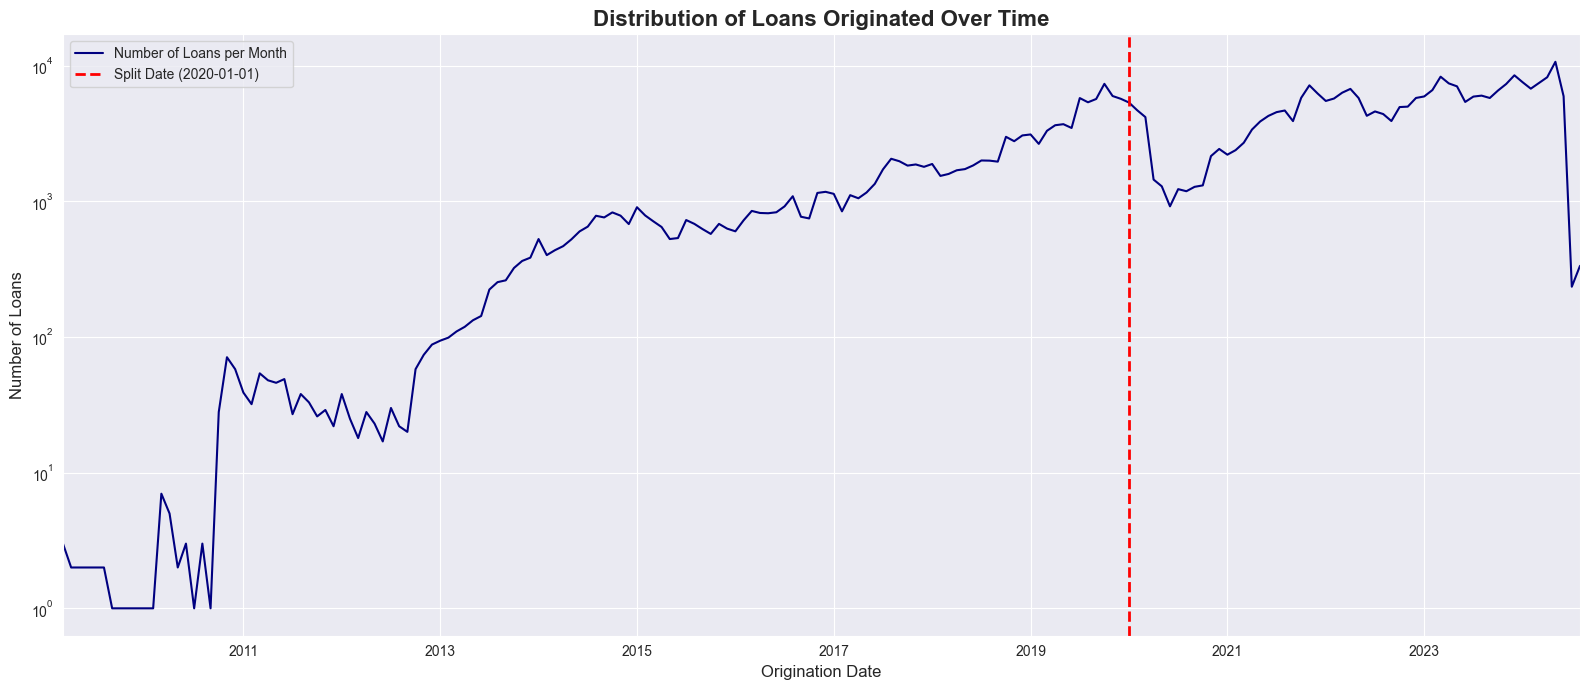

In [36]:
# Visualizing the LoanDate column to understand the distribution of the data over time
loans_by_month = df_cleaned['LoanDate'].dt.to_period('M').value_counts().sort_index()
fig, ax = plt.subplots(figsize=(16, 7))
loans_by_month.plot(kind='line', ax=ax, color='navy', label='Number of Loans per Month')

split_date = pd.to_datetime('2020-01-01') # Note that covid started around this time!
ax.axvline(
    x=split_date.to_period('M'),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Split Date ({split_date.date()})'
)

ax.set_title('Distribution of Loans Originated Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Origination Date', fontsize=12)
ax.set_ylabel('Number of Loans', fontsize=12)
ax.legend()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [37]:
pre_df = df_cleaned[df_cleaned['LoanDate'] < split_date].copy()

# Drop LoanDate so it isn’t fed to the model
pre_df = pre_df.drop(columns=['LoanDate'])


train_df, temp_df = train_test_split(
    pre_df, test_size=0.30, random_state=0, shuffle=False
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=0, shuffle=False
)


X_train, y_train = train_df.drop(columns=['is_default']), train_df['is_default']
X_val,   y_val   = val_df.drop(columns=['is_default']),  val_df['is_default']
X_test,  y_test  = test_df.drop(columns=['is_default']), test_df['is_default']


split_folder = os.path.join('ml', 'NoTransformations')
os.makedirs(split_folder, exist_ok=True)

X_train.to_csv(os.path.join(split_folder, 'X_train.csv'), index=False)
X_val.to_csv(  os.path.join(split_folder, 'X_val.csv'),   index=False)
X_test.to_csv( os.path.join(split_folder, 'X_test.csv'),  index=False)
y_train.to_csv(os.path.join(split_folder, 'y_train.csv'), index=False)
y_val.to_csv(  os.path.join(split_folder, 'y_val.csv'),   index=False)
y_test.to_csv( os.path.join(split_folder, 'y_test.csv'),  index=False)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train target mean: {y_train.mean():.3f}, Validation target mean: {y_val.mean():.3f}, Test target mean: {y_test.mean():.3f}")

Train shape: (89932, 51), Validation shape: (19271, 51), Test shape: (19272, 51)
Train target mean: 0.566, Validation target mean: 0.587, Test target mean: 0.538


## Transforming and Encoding
A neural network requires numerical input, so we will apply feature scaling and one-hot encoding to the dataset. We will use `StandardScaler` for numerical features and `OneHotEncoder` for categorical features. The `ColumnTransformer` will help us apply these transformations selectively to the appropriate columns.

In [38]:
# columns
num_cols = X_train.select_dtypes(include=["number"], exclude=["bool"]).columns
bool_cols = X_train.select_dtypes(include=["bool"]).columns
cat_cols  = X_train.select_dtypes(include=["category"]).columns.union(bool_cols)

# pipeline
preproc = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
])

# fit & transform
X_train_tf = preproc.fit_transform(X_train)
X_val_tf   = preproc.transform(X_val)
X_test_tf  = preproc.transform(X_test)

# output directory
out = "ml/StandardScalerOneHotEncoder"
os.makedirs(out, exist_ok=True)

# feature names
if hasattr(preproc, "get_feature_names_out"):
    feat_names = preproc.get_feature_names_out()
else:
    feat_names = [f"f{i}" for i in range(X_train_tf.shape[1])]

# create DataFrames
df_X_train = pd.DataFrame(X_train_tf, columns=feat_names)
df_X_val   = pd.DataFrame(X_val_tf,   columns=feat_names)
df_X_test  = pd.DataFrame(X_test_tf,  columns=feat_names)

# save transformed features
df_X_train.to_csv(f"{out}/X_train.csv", index=False)
df_X_val.to_csv(f"{out}/X_val.csv",     index=False)
df_X_test.to_csv(f"{out}/X_test.csv",   index=False)

# save targets
y_train.to_frame("is_default").to_csv(f"{out}/y_train.csv", index=False)
y_val.to_frame("is_default").to_csv(f"{out}/y_val.csv",     index=False)
y_test.to_frame("is_default").to_csv(f"{out}/y_test.csv",   index=False)

In [39]:
# Inspect the transformed data
df_X_train

,num__Age,num__OccupationArea,num__HomeOwnershipType,num__AppliedAmount,num__LoanDuration,num__ExistingLiabilities,num__RefinanceLiabilities,num__LiabilitiesTotal,num__IncomeTotal,num__NoOfPreviousLoansBeforeLoan,...,cat__NoOfPreviousLoansBeforeLoan_missing_True,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_False,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_True,cat__PreviousRepaymentsBeforeLoan_missing_False,cat__PreviousRepaymentsBeforeLoan_missing_True,cat__VerificationType_0.0,cat__VerificationType_1.0,cat__VerificationType_2.0,cat__VerificationType_3.0,cat__VerificationType_4.0
0,1.018455,-0.246404,-0.842229,-0.250383,0.961711,1.192052,5.369020,-0.056259,-0.222399,-0.211725,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.773440,0.844834,-0.842229,0.102849,0.961711,0.073606,-0.248187,0.166433,-0.123686,-0.211725,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.283409,1.026707,1.703508,3.183028,0.961711,0.912440,2.560416,0.315759,-0.069448,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.120066,-0.246404,-0.478552,-0.502691,0.961711,-0.765229,-0.248187,-0.175942,-0.130375,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.533308,-0.246404,-0.114875,-0.464340,0.174334,0.353217,1.624215,0.346768,-0.160387,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89927,0.365081,-0.610150,-0.842229,-0.765092,-0.613042,0.632829,-0.248187,-0.241334,-0.096567,2.432474,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
89928,1.590157,-0.610150,-0.842229,0.393508,0.961711,-1.044840,-0.248187,-0.486024,-0.109222,-0.652425,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
89929,0.283409,-0.610150,-0.842229,-0.680316,0.961711,0.073606,-0.248187,-0.368600,-0.139957,0.669674,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
89930,-1.268354,-0.610150,-0.114875,2.109204,0.961711,-0.485617,-0.248187,-0.351005,-0.144477,0.669674,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [40]:
df_X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89932 entries, 0 to 89931
Columns: 102 entries, num__Age to cat__VerificationType_4.0
dtypes: float64(102)
memory usage: 70.0 MB


In [41]:
df_X_train.head()

,num__Age,num__OccupationArea,num__HomeOwnershipType,num__AppliedAmount,num__LoanDuration,num__ExistingLiabilities,num__RefinanceLiabilities,num__LiabilitiesTotal,num__IncomeTotal,num__NoOfPreviousLoansBeforeLoan,...,cat__NoOfPreviousLoansBeforeLoan_missing_True,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_False,cat__PreviousEarlyRepaymentsCountBeforeLoan_missing_True,cat__PreviousRepaymentsBeforeLoan_missing_False,cat__PreviousRepaymentsBeforeLoan_missing_True,cat__VerificationType_0.0,cat__VerificationType_1.0,cat__VerificationType_2.0,cat__VerificationType_3.0,cat__VerificationType_4.0
0,1.018455,-0.246404,-0.842229,-0.250383,0.961711,1.192052,5.369020,-0.056259,-0.222399,-0.211725,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.773440,0.844834,-0.842229,0.102849,0.961711,0.073606,-0.248187,0.166433,-0.123686,-0.211725,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.283409,1.026707,1.703508,3.183028,0.961711,0.912440,2.560416,0.315759,-0.069448,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.120066,-0.246404,-0.478552,-0.502691,0.961711,-0.765229,-0.248187,-0.175942,-0.130375,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.533308,-0.246404,-0.114875,-0.464340,0.174334,0.353217,1.624215,0.346768,-0.160387,-0.652425,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
df_X_train.isna().sum().to_frame('missing_count').sort_values('missing_count', ascending=False)

,missing_count
num__Age,0
cat__MonthlyPaymentDay_4,0
cat__MonthlyPaymentDay_14,0
cat__MonthlyPaymentDay_13,0
cat__MonthlyPaymentDay_12,0
...,...
cat__AmountOfPreviousLoansBeforeLoan_missing_False,0
num__LoanAmountDurationInteraction,0
num__DebtFreeCashInteraction,0
num__LoanQuarter,0
